In [381]:
import pandas as pd
import numpy as np
import sqlalchemy
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

In [382]:
%matplotlib notebook

In [383]:
matplotlib.rcParams.update({'font.size': 15})

In [384]:
from attU.sql import psql_load

## Load Data

In [5]:
df = pd.read_pickle('cleaned_eligibility_data')

9495 unique tickets for 12845 comments in our restricted set, removing 'chat ended' comments.

**Ignored**:  
ticket tags, requester tags, author tags  
account number, call duration, voice type, comment id, author name, author id

## Label tickets that contain just macro responses or are follow ups to queries

Find tickets that don't contain timestamps, and from those find macros

In [6]:
df['text_type'] = df.comment_text.\
map(lambda x: re.search(r'\((1[0-2]|0?[1-9]):([0-5]?[0-9]):([0-5]?[0-9]) ([AP]M)?\)', x)).\
map(lambda x: 'chat' if x else 'macro')

### ID lines from requester

Assuming first line is from requester (only true for non-macro, first interaction tickets)

In [7]:
df_first_chat = df[df.text_type=='chat'].drop_duplicates(subset=['t_id']).copy()

In [8]:
re.search(r'\(.+:.+:.+ [AP]M\) (.+?):', df_first_chat.iloc[0].comment_text.split('\n')[1]).group(0)

'(09:57:41 PM) Jeannie:'

In [9]:
print(df_first_chat.iloc[0].comment_text)

 
(09:57:41 PM) Jeannie: Hi
(09:58:11 PM) Shane C.: Hi Jeannie
(09:58:13 PM) Shane C.: How are you?
(09:58:22 PM) Jeannie: HI Shane
(09:58:50 PM) Jeannie: In reg to quote for "Fresh Donuts Inc"
(09:58:58 PM) Jeannie: they are bakery with cooking
(09:59:06 PM) Jeannie: not sure what's the best class I should go with
(09:59:47 PM) Jeannie: I choose on buz category for Restaurant fast food, class as Donut shops
(09:59:53 PM) Jeannie: not sure if this is appropriate?
(10:00:00 PM) Jeannie: there is no specific bakery with cooking
(10:00:11 PM) Shane C.: Bakeries-Retail-With Baking on Premises 71311
(10:00:37 PM) Shane C.: I think this would be the best class code under processing and servicing
(10:01:12 PM) Jeannie: How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)
(10:02:47 PM) Jeannie: Have a great day. TY
(10:03:07 PM) Shane C.: My pleasure. Is there anything else I can help with at the moment?
(10:03:19 PM) Jeannie: I'm good now. TY :)
(10:03:39

In [10]:
def separate_chats(text):
    customer_chats = []
    agent_chats = []
    #
    for line in text.split('\n'):
        #check for timestamp-name pair in chat
        search = re.search(r'\(.+:.+:.+ [AP]M\) (.+?):', line)
        if search:
            #extract name
            name = search.group(1)
            #remove timestamp-name from chat
            line=line.replace(search.group(0),'').strip()
            if not customer_chats:
                c_name=name
                customer_chats.append(line)
            elif name==c_name:
                customer_chats.append(line)
            else:
                agent_chats.append(line)
    return [customer_chats, agent_chats]

In [11]:
separate_chats(df_first_chat.iloc[0].comment_text)

[['Hi',
  'HI Shane',
  'In reg to quote for "Fresh Donuts Inc"',
  'they are bakery with cooking',
  "not sure what's the best class I should go with",
  'I choose on buz category for Restaurant fast food, class as Donut shops',
  'not sure if this is appropriate?',
  'there is no specific bakery with cooking',
  'How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)',
  'Have a great day. TY',
  "I'm good now. TY :)"],
 ['Hi Jeannie',
  'How are you?',
  'Bakeries-Retail-With Baking on Premises 71311',
  'I think this would be the best class code under processing and servicing',
  'My pleasure. Is there anything else I can help with at the moment?',
  'Any time. Enjoy the rest of your night :)']]

In [12]:
separated_chats = df_first_chat.comment_text.map(separate_chats)

In [13]:
#string of customer chats
df_first_chat['customer_chats'] = separated_chats.map(lambda x: x[0])

In [14]:
df_first_chat['agent_chats'] = separated_chats.map(lambda x: x[1])

### Timestamp features

In [38]:
def extract_ts_features(row):
    try:
        text = row['comment_text']
        ts = [pd.to_datetime(tstring.replace('(','').replace(')','')) for tstring \
              in re.findall(r'\(.+:.+:.+M\)', text)]
        total = (ts[-1]-ts[0]).total_seconds()/60
        diffs = [d.total_seconds()/60 for d in np.diff(ts)]
        return [row['t_id'],total, round(total), np.mean(diffs), np.max(diffs), np.std(diffs)]
    except:
        return None

In [39]:
#consider only chat tickets and keep the first of duplicate ticket IDs
ts_features = pd.DataFrame(data=df_first_chat.apply(extract_ts_features,axis=1).dropna().array,
                           columns=['t_id','total_time','rounded_total_time','mean_diff','max_diff','std_diff'])

//anaconda3/envs/zendesk/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/envs/zendesk/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


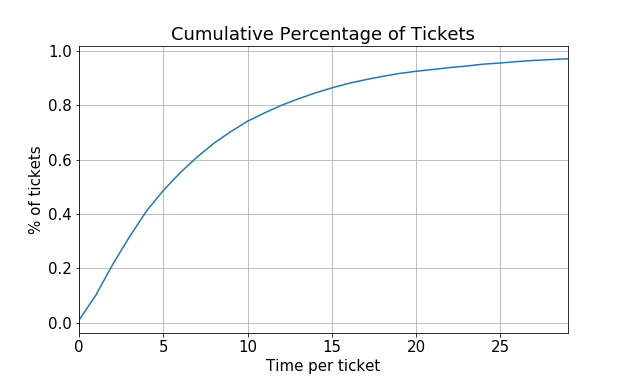

In [1270]:
#cumulative percentage of num tickets per bucket of rounded time spent per ticket
fig, ax = plt.subplots(figsize=(10,6))
# fig, ax = plt.subplots()

(ts_features.groupby('rounded_total_time')['t_id'].count().cumsum()/\
 ts_features.t_id.unique().size)[:30].\
plot(ax=ax)

ax.set_ylabel('% of tickets')
ax.set_xlabel('Time per ticket')
ax.set_title('Cumulative Percentage of Tickets')

ax.grid(which='major')

1/3 of tickets take under ~3.1 minutes,   
1/2 under ~5.3 minutes

In [59]:
#round, group by time, count
# multiply count*time to find total time used by small tickets
tix_by_time_bucket = pd.DataFrame(
    ts_features.groupby('rounded_total_time')['t_id'].count()
).rename(columns={'t_id':'tid_count'}).reset_index()

In [60]:
def time_all_tickets(row):
    ticket_time_bin = row['rounded_total_time']
    tc = row['tid_count']
    if ticket_time_bin==0:
        return 0.5*tc
    else:
        return ticket_time_bin*tc

In [61]:
tix_by_time_bucket['time_all_tickets'] = tix_by_time_bucket.apply(time_all_tickets, axis=1)

<IPython.core.display.Javascript object>


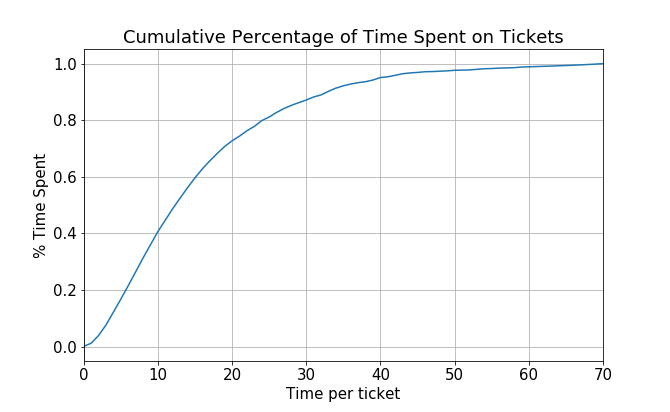

In [1271]:
fig, ax = plt.subplots(figsize=(8,6))

(tix_by_time_bucket.time_all_tickets.cumsum()/tix_by_time_bucket.time_all_tickets.sum()).plot(ax=ax)

ax.set_ylabel('% Time Spent')
ax.set_xlabel('Time per ticket')
ax.set_title('Cumulative Percentage of Time Spent on Tickets')

ax.grid(which='major')

Tickets under 5.3 minutes represented only 18% of agents' time.  
Tickets under 12.5 minutes represent 50% of agents' time.

<IPython.core.display.Javascript object>


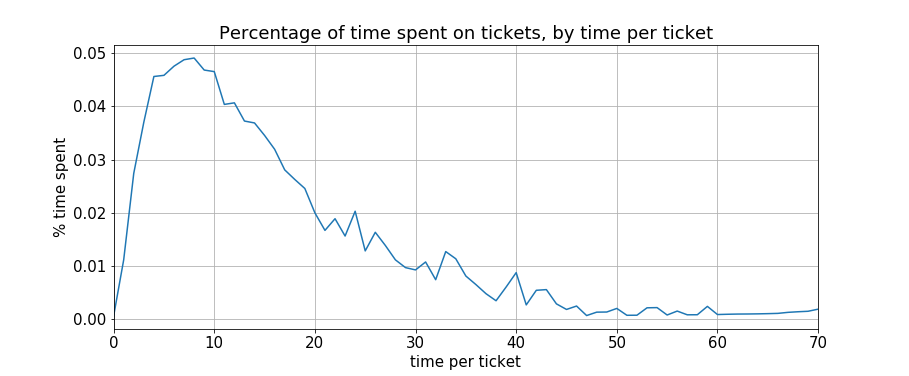

In [84]:
fig, ax = plt.subplots()

(tix_by_time_bucket.time_all_tickets/tix_by_time_bucket.time_all_tickets.sum()).plot(ax=ax)

ax.set_ylabel('% time spent')
ax.set_xlabel('time per ticket')
ax.set_title('Percentage of time spent on tickets, by time per ticket')

ax.grid()

Add line counts

In [85]:
df_first_chat['line_counts'] = df_first_chat.comment_text.str.count('\n')

In [86]:
df_first_chat.count()

t_id              9482
t_created         9482
r_name            9482
r_id              9482
a_id              9482
a_name            9482
subject           9481
comment_text      9482
text_type         9482
customer_chats    9482
agent_chats       9482
line_counts       9482
dtype: int64

In [658]:
ts_features.count()

t_id                9458
total_time          9458
mean_diff           9458
max_diff            9458
std_diff            9458
round_total_time    9458
dtype: int64

In [87]:
#merge df and ts features
df_pipe = df_first_chat.merge(ts_features.dropna(), on='t_id', how='left')

<IPython.core.display.Javascript object>


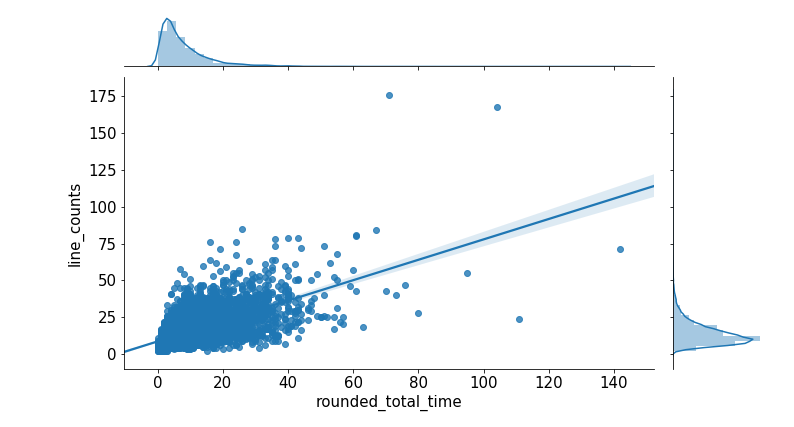

In [91]:
#correlate lines and time
sns.jointplot(df_pipe.rounded_total_time, df_pipe.line_counts, 
              kind='reg')

In [92]:
df_pipe.corr()

line_counts  total_time  rounded_total_time  mean_diff  \
line_counts            1.000000    0.642470            0.642170  -0.048689   
total_time             0.642470    1.000000            0.999390   0.532267   
rounded_total_time     0.642170    0.999390            1.000000   0.531350   
mean_diff             -0.048689    0.532267            0.531350   1.000000   
max_diff               0.239735    0.762493            0.761824   0.725684   
std_diff               0.089710    0.654258            0.653521   0.798454   

                    max_diff  std_diff  
line_counts         0.239735  0.089710  
total_time          0.762493  0.654258  
rounded_total_time  0.761824  0.653521  
mean_diff           0.725684  0.798454  
max_diff            1.000000  0.948444  
std_diff            0.948444  1.000000

<IPython.core.display.Javascript object>


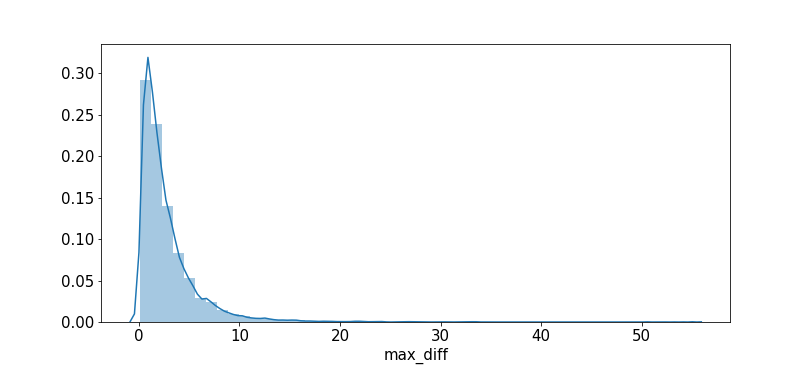

In [103]:
sns.distplot(ts_features.max_diff)

In [95]:
df_pipe.columns

Index(['t_id', 't_created', 'r_name', 'r_id', 'a_id', 'a_name', 'subject',
       'comment_text', 'text_type', 'customer_chats', 'agent_chats',
       'line_counts', 'total_time', 'rounded_total_time', 'mean_diff',
       'max_diff', 'std_diff'],
      dtype='object')

Examine text of clusters

In [226]:
# for i in df_pipe[df_pipe.rounded_total_time<=3].sample(5)[['comment_text','customer_chats']].iterrows():
#     print('-------------')
#     print(i[1]['comment_text'])
#     print('CUSTOMER CHATS')
#     print(' '.join(i[1]['customer_chats'][:]))

### Load Spacy

In [108]:
# from gensim.utils import simple_preprocess
# import nltk; nltk.download('stopwords')

Load spacy medium model (includes word vectors for similarity)

In [385]:
import spacy

In [113]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 95.4MB 25.7MB/s eta 0:00:01
  Stored in directory: /private/var/folders/57/mgcw3l1d5mz13lqz1v5rwmrm0000gp/T/pip-ephem-wheel-cache-tjxvy6zf/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [123]:
!python -m spacy link en_core_web_md en --force

✔ Linking successful
//anaconda3/envs/zendesk/lib/python3.7/site-packages/en_core_web_md -->
//anaconda3/envs/zendesk/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [386]:
nlp = spacy.load('en', disable=['ner','par'])

In [331]:
nlp._meta['name']

'core_web_md'

### Matching and Entity Recognition for ticket intent

In [332]:
from spacy import displacy

In [336]:
ex = [{"text": "But Google is starting from behind.",
       "ents": [{"start": 4, "end": 10, "label": ''}],
       "title": None}]
html = displacy.render(ex, style="ent", manual=True)

In [233]:
i=4
print('. '.join(df_pipe.customer_chats.iloc[i]))
testdoc = nlp('. '.join(df_pipe.customer_chats.iloc[i]))
list(testdoc.ents)

Question. Been Better. Question. Commercial Co-op, all offices , 6 stories, with restaurant on first floor. The Person who cares for building , Superintendent is only person living there. Is that a problem?. THX, So Long


[Commercial Co-op, 6, first, THX]

In [234]:
displacy.render(testdoc, style='ent', jupyter=True)

In [271]:
def print_sample(df, n):
    for i in df.sample(n)[['comment_text','customer_chats','agent_chats']].iterrows():
        print('-------------')
        print(i[1]['comment_text'])
        print('CUSTOMER')
        print(' '.join(i[1]['customer_chats'][:]))
        print('AGENT')
        print(' '.join(i[1]['agent_chats'][:]))

In [953]:
def text_in_col(df, col, text, count=False):
    '''return filtered df for text in df column. If count return value counts instead.'''
    if isinstance(text,str):
        text = [text]
    elif not isinstance(text,list):
        raise TypeError("'text' should be string or list")
        
    filtered = df[col].map(lambda x: any([t in ' '.join(x).lower() for t in text]))
    
    if count:
        print('absolute-------')
        print(filtered.value_counts())
        print('percentage-----')
        print(filtered.value_counts()/filtered.value_counts().sum())
    else:
        return df[filtered]

### Clean, use first few lines as query and use spacy similarity search

request markers: blackboard, attune, write, consider

request intent: confirming/making sure, decline(check mistakes, highlight reason for decline with guideline match, send more documentation to help)

In [954]:
158/df_pipe['t_id'].count()

0.016663151233916894

In [1321]:
text = ['lro']
df = df_pipe[df_pipe.rounded_total_time<=5]
col = 'customer_chats'

print(text_in_col(df,col,text, count=True))
print_sample(text_in_col(df,col,text, count=False), 6)

absolute-------
False    4027
True      566
Name: customer_chats, dtype: int64
percentage-----
False    0.876769
True     0.123231
Name: customer_chats, dtype: float64
None
-------------
 
(07:05:54 PM) chris: hello
(07:06:02 PM) Andrianna Q.: Hi Chris
(07:06:06 PM) Andrianna Q.: How are you today?
(07:06:14 PM) chris: its going ok how are you doing
(07:06:35 PM) Andrianna Q.: doing well, thanks for asking
(07:06:35 PM) Andrianna Q.: how can I help you today?
(07:06:56 PM) chris: do you do LRO for an auto repair shop. I can not seem to find a class code
(07:07:16 PM) Andrianna Q.: Unfortunately, that risk is not in our appetite at the moment
(07:07:21 PM) chris: :(
(07:08:33 PM) Andrianna Q.: I wish I there was something I can do to assist
(07:08:40 PM) Andrianna Q.: Is there anything else I can help you with today?
(07:08:58 PM) chris: not at the moment. I have another quote to do so maybe then haha.
(07:09:01 PM) chris: Thank you
(07:10:14 PM) Andrianna Q.: no problem at all. Feel fr

Custom stop words

In [1179]:
greetings = ['hi','good','hey','hello','thank','thanks','morning',
          'afternoon','evening','please','ok','okay','great','welcome','day','today',
          'would','yes','amp','consider','quick','question','nope','thx','ty','add','try','maybe','instead','market']

stop_words = greetings

insurance = ['attune','blackboard','risk','bop','quote','market']

#get list of agent names to remove
agent_names = [n.split()[0].lower() for n in df.a_name.unique()]

stop_words.extend(insurance)
stop_words.extend(agent_names)
# stop_words

lower/stop/token/lemma for first n lines of customer chats

In [1180]:
def lower_stop_punct_lemma(chat_list, first_n_lines):
    '''processes list of customer chats (first n lines)
    and returns unique list of lemmatized tokens.'''
    """https://spacy.io/api/annotation"""
    doc_out = []
    doc = nlp(' '.join(chat_list[:first_n_lines]).lower())
    for token in doc:
        if not (token.is_punct or token.is_stop):
            lemma = token.lemma_
            if (lemma not in stop_words) and (lemma not in doc_out):
                doc_out.append(lemma)
    return nlp(' '.join(doc_out))

In [1181]:
df_pipe.customer_chats.iloc[47]

['Hi, can I quote a bakery wholesaler/distributor under the bakery retail class?',
 'thank you',
 'ok so its not eligible to quote?',
 'ok thanks for checking',
 'have a ncie day']

In [1182]:
lower_stop_punct_lemma(df_pipe.customer_chats.iloc[47],3)

bakery wholesaler distributor retail class eligible

In [1183]:
#apply to corpus
df_pipe['cleaned_customer_chats'] = df_pipe.customer_chats.map(lambda x: lower_stop_punct_lemma(x,3))

In [1184]:
df_pipe.to_pickle('df_pipe_cleaned_3')

In [6]:
df_pipe = pd.read_pickle('df_pipe_cleaned_3')

### Try for all tickets, brute force

In [1185]:
#general topics by phrase matcher (class code, reason declined, lro)
#use thorough stowords for specific business types

In [345]:
doc = nlp('beauty salon lro')
sim_scores = df_pipe['cleaned_customer_chats'].map(lambda x: x.similarity(doc))

In [349]:
sim_scores.sort_values(ascending=False)[:5]

744     0.887009
605     0.887009
1917    0.823761
5102    0.809426
6738    0.800366
Name: cleaned_customer_chats, dtype: float64

In [350]:
df_pipe.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
2  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   
3  148929 2019-09-19 21:21:50        Georgette Diaz  377333939872   
4  148925 2019-09-19 21:19:42     Vincent Mosomillo  363659707672   

           a_id    a_name                     subject  \
0  374984390592  Shane C.           Chat with Jeannie   
1  374984390592  Shane C.            Chat with denise   
2  374984390592  Shane C.         Chat with jeff wolf   
3  374984390592  Shane C.    Chat with georgette diaz   
4  374984390592  Shane C.  Chat with Vncent Mosomillo   

                                        comment_text text_type  \
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...      chat   
1   \n(09:22:45 PM) denise: Do you allow electric...      chat   
2   \n(09:21:52 PM) jeff wolf: what is best class...      chat   
3   \n(09:21:24 PM) georgette diaz: quick questio...      chat   
4   \n(09:19:05 PM) Vncent Mosomillo: Question\n(...      chat   

                                      customer_chats  ... line_counts  \
0  [Hi, HI Shane, In reg to quote for "Fresh Donu...  ...          17   
1  [Do you allow electrical contractors to instal...  ...          12   
2  [what is best classification for fence erectio...  ...          50   
3  [quick question what bakery classification do ...  ...           8   
4  [Question, Been Better, Question, Commercial C...  ...          10   

   total_time  rounded_total_time  mean_diff  max_diff  std_diff  \
0    5.966667                 6.0   0.372917  1.583333  0.364286   
1   13.750000                14.0   1.375000  3.583333  1.163907   
2   19.883333                20.0   0.414236  3.033333  0.500613   
3    1.800000                 2.0   0.257143  0.400000  0.112637   
4    3.233333                 3.0   0.359259  0.716667  0.236632   

                              cleaned_customer_chats dominant_topic  \
0                           (reg, fresh, donut, inc)            NaN   
1  (allow, electrical, contractor, install, solar...            NaN   
2  (classification, fence, erection, staining, ti...            NaN   
3  (bakery, classification, bakes, pastry, cake, ...            9.0   
4                                             (well)            7.0   

         top2_topics broker_type  
0                NaN      active  
1                NaN      active  
2                NaN    inactive  
3   [Topic9, Topic7]    inactive  
4  [Topic7, Topic14]      active  

[5 rows x 21 columns]

In [1186]:
df_cleaned = df_pipe[['t_id','cleaned_customer_chats']].copy()

In [744]:
def get_similar_doc_inds(doc, thresh):
    sim_scores = df_cleaned['cleaned_customer_chats'].map(lambda x: x.similarity(doc))
    return sim_scores[sim_scores>=thresh].index

In [794]:
df_cleaned['topic'] = None
inds = df_cleaned.index
topic_num = 0

for ind in inds:
    doc = df_cleaned.cleaned_customer_chats.iloc[ind]
    #returns indices of similar docs 
    similar_doc_inds = get_similar_doc_inds(doc, .65)
    if not similar_doc_inds.empty:
        #assign topic number to original doc
        df_cleaned.loc[ind, 'topic'] = topic_num
        #remove from inds list
        inds = inds.difference(similar_doc_inds)
        #[inds.remove(i) for i in similar_doc_inds]
        #assign topic number to similar docs
        df_cleaned.loc[similar_doc_inds,'topic'] = topic_num
        topic_num+=1

In [795]:
# df_cleaned.topic.value_counts()

In [343]:
import warnings

In [344]:
warnings.simplefilter('ignore')

### Check longer tickets

In [1187]:
df_pipe[(df_pipe.rounded_total_time>5) & (df_pipe.rounded_total_time<=10)].count()

t_id                      2416
t_created                 2416
r_name                    2416
r_id                      2416
a_id                      2416
a_name                    2416
subject                   2416
comment_text              2416
text_type                 2416
customer_chats            2416
agent_chats               2416
line_counts               2416
total_time                2416
rounded_total_time        2416
mean_diff                 2416
max_diff                  2416
std_diff                  2416
cleaned_customer_chats    2416
dominant_topic               0
top2_topics                  0
broker_type               2416
dtype: int64

### didn't work, back to focusing on simple tickets

Vectorize

In [387]:
df_pipe.cleaned_customer_chats.head()

0                             (reg, fresh, donut, inc)
1    (allow, electrical, contractor, install, solar...
2    (classification, fence, erection, staining, ti...
3    (bakery, classification, bakes, pastry, cake, ...
4                                               (well)
Name: cleaned_customer_chats, dtype: object

In [388]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [389]:
time_threshold = 5

In [390]:
#prepare data for vectorizer, requires doc strings so join tokens
data = df_pipe[df_pipe.rounded_total_time<=time_threshold].\
cleaned_customer_chats.map(lambda x: x.text)
print(data.count())

4593


In [391]:
# vectorize
vectorizer = CountVectorizer(min_df=5, max_df=0.9, max_features=9000)

In [392]:
#get matrix of document-wordcount vectors (rows)
data_vectorized = vectorizer.fit_transform(data)

Examine vocabulary

In [393]:
data_vectorized.sum(axis=0).shape

(1, 1111)

In [394]:
data_vectorized.sum(axis=0)

matrix([[76, 53, 31, ..., 15,  6,  8]], dtype=int64)

In [395]:
#sum across this axis will be total frequency of words in doc, yields matrix
sum_words = data_vectorized.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [396]:
print(sorted(words_freq, key=lambda x: x[1], reverse=True)[:15])

[('write', 940), ('class', 746), ('store', 683), ('lro', 531), ('office', 496), ('building', 471), ('code', 432), ('tenant', 368), ('restaurant', 358), ('lessor', 324), ('use', 316), ('business', 294), ('want', 283), ('need', 279), ('shop', 256)]


lda

In [397]:
from sklearn.decomposition import LatentDirichletAllocation

In [398]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=10, max_iter=10, random_state=0, 
                                learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [399]:
import pprint

In [400]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=15):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        pprint.pprint([(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]) 
        print('\n')

In [1203]:
# selected_topics(lda, vectorizer);

In [1205]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(data_vectorized))

# See model parameters
pprint.pprint(lda.get_params())

Log Likelihood:  -219843.1345338682
Perplexity:  725.3581292030336
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 15,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': True}


### Grid Search

In [1167]:
from sklearn.model_selection import GridSearchCV

In [1246]:
# Define Search Param
search_params = {'n_components': [25, 30, 35, 40], 'learning_decay': [.7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

//anaconda3/envs/zendesk/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                  

In [1247]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 25}
Best Log Likelihood Score:  -184656.19474149408
Model Perplexity:  1276.8821136043596


In [1248]:
results_df = pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score')

In [1249]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_decay', 'param_n_components', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [1250]:
results_df[['rank_test_score','params','mean_test_score']].sort_values(by='rank_test_score')

rank_test_score                                       params  \
0                1  {'learning_decay': 0.7, 'n_components': 25}   
4                2  {'learning_decay': 0.9, 'n_components': 25}   
1                3  {'learning_decay': 0.7, 'n_components': 30}   
5                4  {'learning_decay': 0.9, 'n_components': 30}   
2                5  {'learning_decay': 0.7, 'n_components': 35}   
6                6  {'learning_decay': 0.9, 'n_components': 35}   
3                7  {'learning_decay': 0.7, 'n_components': 40}   
7                8  {'learning_decay': 0.9, 'n_components': 40}   

   mean_test_score  
0   -184656.194741  
4   -185559.867417  
1   -186500.639118  
5   -187826.276653  
2   -188164.014577  
6   -189319.344379  
3   -189644.397388  
7   -191178.643356

In [1251]:
new_params = results_df.iloc[-2]['params']
tlda = model.best_estimator_.set_params(**new_params)

In [1252]:
tlda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=40, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [1253]:
tlda.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=40, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

### Plotting LDA

In [401]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn

//anaconda3/envs/zendesk/lib/python3.7/site-packages/jinja2/utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping


In [402]:
pyLDAvis.enable_notebook()

In [405]:
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      141.506378  -22.229671       1        1  15.920549
9      -90.096367    1.355309       2        1  13.327017
7       14.198476 -126.266602       3        1  12.415231
5       49.606224  -39.679771       4        1  11.559521
4      -51.743763   84.333549       5        1   9.481582
6      -40.028423  -64.154984       6        1   9.292036
0       91.445030   43.287308       7        1   8.061708
8      103.152832 -105.208221       8        1   8.031109
2        1.807978   18.809698       9        1   7.126837
3       37.210754  105.394302      10        1   4.784410, topic_info=     Category        Freq         Term       Total  loglift  logprob
1101  Default  915.000000        write  915.000000  30.0000  30.0000
967   Default  663.000000        store  663.000000  29.0000  29.0000
612   Default  502.000000          lro  502.000000  28.0000  28.0000
468   Default  187.000000          guy  187.000000  27.0000  27.0000
1068  Default  279.000000         want  279.000000  26.0000  26.0000
215   Default  735.000000        class  735.000000  25.0000  25.0000
231   Default  429.000000         code  429.000000  24.0000  24.0000
1002  Default  345.000000       tenant  345.000000  23.0000  23.0000
871   Default  344.000000   restaurant  344.000000  22.0000  22.0000
692   Default  272.000000         need  272.000000  21.0000  21.0000
581   Default  308.000000       lessor  308.000000  20.0000  20.0000
308   Default  172.000000      decline  172.000000  19.0000  19.0000
401   Default  141.000000         find  141.000000  18.0000  18.0000
602   Default  196.000000     location  196.000000  17.0000  17.0000
916   Default  247.000000         shop  247.000000  16.0000  16.0000
356   Default  222.000000     eligible  222.000000  15.0000  15.0000
164   Default  452.000000     building  452.000000  14.0000  14.0000
985   Default  203.000000         sure  203.000000  13.0000  13.0000
459   Default  125.000000      grocery  125.000000  12.0000  12.0000
872   Default  227.000000       retail  227.000000  11.0000  11.0000
833   Default  155.000000         rate  155.000000  10.0000  10.0000
329   Default  115.000000  distributor  115.000000   9.0000   9.0000
202   Default  144.000000        check  144.000000   8.0000   8.0000
416   Default  120.000000         food  120.000000   7.0000   7.0000
712   Default  157.000000       occupy  157.000000   6.0000   6.0000
863   Default  103.000000       repair  103.000000   5.0000   5.0000
819   Default  123.000000     property  123.000000   4.0000   4.0000
977   Default  103.000000   submission  103.000000   3.0000   3.0000
588   Default  156.000000         like  156.000000   2.0000   2.0000
1049  Default  308.000000          use  308.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
221   Topic10   24.762239     cleaning   25.629592   3.0054  -4.1665
96    Topic10   23.577698   assistance   24.445162   3.0037  -4.2155
220   Topic10   23.394520      cleaner   24.261907   3.0034  -4.2233
229   Topic10   20.952886           co   21.820617   2.9992  -4.3335
336   Topic10   17.781160         door   18.649063   2.9922  -4.4977
118   Topic10   17.077274       baking   17.944660   2.9903  -4.5381
1073  Topic10   16.723938       waxing   17.591364   2.9892  -4.5590
383   Topic10   15.863929    extension   16.731356   2.9866  -4.6118
216   Topic10   14.069845    classcode   14.937279   2.9800  -4.7318
907   Topic10   14.054435     separate   14.921998   2.9799  -4.7329
57    Topic10   13.917742           ah   14.785112   2.9794  -4.7427
250   Topic10   12.959178       conner   13.826640   2.9750  -4.8140
777   Topic10   12.091125        plant   12.958453   2.9705  -4.8833
808   Topic10   11.652839   processing   12.520294   2.9680  -4.9203
377   Topic10   11.199644       excess   12.067882   2.9651  -4.9599
1083  Topic10   11

In [406]:
dash.token_table[dash.token_table['Topic']==10].sort_values('Freq',ascending=False).head()

Topic      Freq        Term
term                             
468      10  0.995014         guy
189      10  0.989056    category
117      10  0.983727      bakery
96       10  0.981789  assistance
768      10  0.980592        pick

### Get documents by topic

In [407]:
def get_topn_keywords_topic(model, vectorizer, top_n=10, df=True):
    """Get top n keywords & weights per topic from LDA topic model.
    
    Args:
        model (sklearn model): topic model (LDA) with components
        vectorizer (sklearn vectorizer): Count, TFIDF, etc
        top_n (int, optional): number of keywords per topic. Defaults to 10.
        df (bool, optional): if True (default), return results in pandas DataFrame

    Returns:
        list(list(tuple(str,int))): top keywords & weights per topic for all topics

    """
    results = []
    for topic in model.components_:
        kw_tmp = []
        w_tmp = []
        for i in topic.argsort()[: -top_n - 1 : -1]:
            kw_tmp.append(vectorizer.get_feature_names()[i])
            w_tmp.append(topic[i])
        results.append([kw_tmp, w_tmp])

    if df:
        return pd.DataFrame(
            data={
                "keywords": [i[0] for i in results],
                "weights": [i[1] for i in results],
            }
        )
    else:
        return results


In [408]:
get_topn_keywords_topic(lda, vectorizer, top_n=5, df=True)

keywords  \
0             [store, grocery, rate, sale, happy]   
1       [lro, tenant, eligible, building, lessor]   
2              [find, class, code, wonder, place]   
3       [guy, write, be, submission, residential]   
4       [store, write, retail, lessor, apartment]   
5                  [class, need, code, like, new]   
6  [write, restaurant, food, cooking, contractor]   
7      [location, decline, office, get, property]   
8          [want, shop, sure, write, distributor]   
9                 [class, store, use, code, sell]   

                                             weights  
0  [135.4475758445999, 123.60284638696267, 107.17...  
1  [428.12427179777904, 299.2192444210773, 211.92...  
2  [129.48038808436718, 98.21129541345621, 79.847...  
3  [174.8508333456556, 115.7250115203877, 63.4545...  
4  [302.90521316996694, 222.10333294773716, 117.8...  
5  [277.25200394178364, 207.56760929858785, 205.7...  
6  [310.6510301578751, 216.4783822377751, 126.122...  
7  [186.37190535585336, 182.5687134870884, 152.41...  
8  [209.03904997964653, 137.2695370385498, 132.24...  
9  [265.3805410641278, 225.76717331011432, 198.15...

In [409]:
def get_topn_topics_doc(transformed_data, top_n=3, df=True):
    """Get top n topics and weights per document from data transformed by LDA topic model.
    
    Args:
        transformed_data (numpy matrix): resulting from model.transform(vectorized_data)
        top_n (int, optional): num topics per document. Defaults to 3.

    Returns:
        pandas DataFrame: index is doc number, lists of topics and weights per topic (rounded) 
        in separate columns
        numpy array: 2d array with shape (num_docs, top_n topics), topics sorted descending

    """
    
    topic_inds = np.fliplr(np.argsort(transformed_data, axis=1))[:, :top_n]
    topic_weights = np.round(np.fliplr(np.sort(transformed_data, axis=1)),3)[:, :top_n]
    
    
    if df:
        return pd.DataFrame(
            data={
                "topics": topic_inds.tolist(),
                "weights": topic_weights.tolist()
            }
        )
    else:
        return [topic_inds, topic_weights]

In [412]:
# Create Document - Topic Matrix
# model = tlda
# lda_output = model.transform(data_vectorized)
model=lda
lda_output = data_lda

# column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
# def color_green(val):
#     color = 'green' if val > .1 else 'black'
#     return 'color: {col}'.format(col=color)

# def make_bold(val):
#     weight = 700 if val > .1 else 400
#     return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
# df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

### Topic stats by doc

In [413]:
get_topn_topics_doc(data_lda).head()

topics                weights
0  [4, 3, 9]   [0.517, 0.35, 0.017]
1  [3, 2, 0]     [0.55, 0.05, 0.05]
2  [7, 8, 0]     [0.55, 0.05, 0.05]
3  [8, 4, 9]   [0.623, 0.217, 0.02]
4  [4, 1, 9]  [0.918, 0.009, 0.009]

In [414]:
get_topn_topics_doc(data_lda)['topics'].str[0].value_counts()

1    822
9    820
7    538
5    507
4    442
6    435
8    307
0    295
2    248
3    179
Name: topics, dtype: int64

In [415]:
df_document_topic.groupby('dominant_topic')['Topic0'].count().sort_values(ascending=False)

dominant_topic
1    853
9    615
7    521
5    506
0    484
4    458
6    438
8    275
2    264
3    179
Name: Topic0, dtype: int64

In [1211]:
def ntopics_majority(row,frac):
    '''find nlargest of topics that constitute >=frac of all topics in a doc'''
    #sort, cumsum, indwhere
    c_frac = row.sort_values(ascending=False).cumsum()/row.sum()
    last_ind = c_frac[c_frac>=frac].index[0]
    return c_frac.loc[:last_ind].index.tolist()

In [1212]:
#get numbers of nonzero topics by doc
df_document_topic['nlargest_topics0.9'] = df_document_topic.drop(['dominant_topic'], axis=1).\
apply(lambda x: ntopics_majority(x,.9),axis=1)

In [1213]:
#num topics that are .9 of topic dist per doc
df_document_topic['nlargest_topics0.9'].map(lambda x: len(x)).value_counts()

5     2028
6     1211
10     429
11     251
14     158
12     157
4      132
7      107
3       64
8       29
2       21
9        3
1        3
Name: nlargest_topics0.9, dtype: int64

In [1214]:
#top 5
df_document_topic['nlargest_topics0.9'].map(lambda x: len(x[:5])).value_counts()

5    4373
4     132
3      64
2      21
1       3
Name: nlargest_topics0.9, dtype: int64

In [1215]:
df_document_topic['top2_topics'] = df_document_topic['nlargest_topics0.9'].map(lambda x: x[:2])

In [1216]:
df_document_topic.top2_topics.map(lambda x: x[0]).value_counts()

Topic4     630
Topic11    572
Topic14    543
Topic10    537
Topic9     399
Topic7     399
Topic1     342
Topic12    238
Topic6     210
Topic2     161
Topic5     161
Topic13    135
Topic8     116
Topic0      99
Topic3      51
Name: top2_topics, dtype: int64

In [1217]:
df_document_topic.top2_topics.map(lambda x: x[1] if len(x)>1 else None).dropna().value_counts()

Topic14    729
Topic11    420
Topic10    411
Topic9     383
Topic13    368
Topic4     350
Topic1     332
Topic7     299
Topic5     242
Topic6     238
Topic2     202
Topic12    195
Topic8     179
Topic0     147
Topic3      95
Name: top2_topics, dtype: int64

Primary and secondary topics distributions.

In [987]:
import itertools

In [1465]:
tt = set(pd.Series(list(itertools.chain.from_iterable(df_document_topic.top5_topics.values))).value_counts()[:15].index)

In [1472]:
dt.union(set(map(lambda x: int(x[5:]),list(tt))))

{0, 4, 7, 10, 12, 14, 16, 18, 22, 26, 27, 32, 33, 37, 38, 39}

### Representative docs per topic

In [416]:
df_document_topic.head(4)

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  Topic8  \
Doc0    0.02    0.02    0.02    0.35    0.52    0.02    0.02    0.02    0.02   
Doc1    0.05    0.05    0.05    0.55    0.05    0.05    0.05    0.05    0.05   
Doc2    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.55    0.05   
Doc3    0.02    0.02    0.02    0.02    0.22    0.02    0.02    0.02    0.62   

      Topic9  dominant_topic  
Doc0    0.02               4  
Doc1    0.05               3  
Doc2    0.05               7  
Doc3    0.02               8

In [1234]:
# df_pipe.drop(['dominant_topic_x','top2_topics_x','top2_topics_y','dominant_topic_y'], inplace=True, axis=1)

In [417]:
df_document_topic['index_data'] = data.index

In [421]:
df_pipe.drop(['dominant_topic','top2_topics'], axis=1, inplace=True)

In [423]:
df_pipe = df_pipe.merge(df_document_topic[['dominant_topic','index_data']].set_index('index_data'), 
              how='left', left_index=True, right_index=True)

In [424]:
df_pipe.head(4)

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
2  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   
3  148929 2019-09-19 21:21:50        Georgette Diaz  377333939872   

           a_id    a_name                   subject  \
0  374984390592  Shane C.         Chat with Jeannie   
1  374984390592  Shane C.          Chat with denise   
2  374984390592  Shane C.       Chat with jeff wolf   
3  374984390592  Shane C.  Chat with georgette diaz   

                                        comment_text text_type  \
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...      chat   
1   \n(09:22:45 PM) denise: Do you allow electric...      chat   
2   \n(09:21:52 PM) jeff wolf: what is best class...      chat   
3   \n(09:21:24 PM) georgette diaz: quick questio...      chat   

                                      customer_chats  \
0  [Hi, HI Shane, In reg to quote for "Fresh Donu...   
1  [Do you allow electrical contractors to instal...   
2  [what is best classification for fence erectio...   
3  [quick question what bakery classification do ...   

                                         agent_chats  line_counts  total_time  \
0  [Hi Jeannie, How are you?, Bakeries-Retail-Wit...           17    5.966667   
1  [Hi Denise, How are you?, I am doing well. Alm...           12   13.750000   
2  [Hi Jeff, How are you?, Fence Erection Contrac...           50   19.883333   
3  [Hi Georgette, How are you?, That is good to h...            8    1.800000   

   rounded_total_time  mean_diff  max_diff  std_diff  \
0                 6.0   0.372917  1.583333  0.364286   
1                14.0   1.375000  3.583333  1.163907   
2                20.0   0.414236  3.033333  0.500613   
3                 2.0   0.257143  0.400000  0.112637   

                              cleaned_customer_chats broker_type  \
0                           (reg, fresh, donut, inc)      active   
1  (allow, electrical, contractor, install, solar...      active   
2  (classification, fence, erection, staining, ti...    inactive   
3  (bakery, classification, bakes, pastry, cake, ...    inactive   

   dominant_topic  
0             NaN  
1             NaN  
2             NaN  
3             4.0

Display topic words

In [425]:
def get_representative_docs(topic_number):
    inds = df_document_topic.groupby('dominant_topic')['index_data'].get_group(topic_number).values
    print('Num representative docs: {}'.format(len(inds)))
    return df_pipe.loc[inds]

In [426]:
def print_sample(df, n):
    for i in df.sample(n)[['comment_text','customer_chats','cleaned_customer_chats']].iterrows():
        print('-------------')
        print(i[1]['comment_text'])
        print('CUSTOMER')
        print(' '.join(i[1]['customer_chats'][:]))
        print('CLEANED')
        print(i[1]['cleaned_customer_chats'])

In [1240]:
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
11    -150.924362  139.094528       1        1  10.671253
10    -361.085785   68.431976       2        1  10.633684
4      136.935989  -38.802368       3        1  10.601039
9     -341.182526 -147.999054       4        1   9.207338
7     -185.948227 -291.254700       5        1   8.904572
1       -2.442959 -165.883133       6        1   8.337688
14     -55.824516  340.665009       7        1   6.945893
6       18.611885 -382.687012       8        1   5.400878
5      281.962921  129.169571       9        1   5.340333
2      350.649658  -83.420433      10        1   5.242137
12     206.605087 -257.008423      11        1   5.085888
0       35.566799  115.575859      12        1   4.062610
13     157.400757  299.376648      13        1   3.357674
8     -144.866180  -48.419643      14        1   3.254814
3     -289.596375  296.616608      15        1   2.954199, topic_info=     Category        Freq            Term       Total  loglift  logprob
967   Default  639.000000           store  639.000000  30.0000  30.0000
1101  Default  901.000000           write  901.000000  29.0000  29.0000
215   Default  711.000000           class  711.000000  28.0000  28.0000
715   Default  473.000000          office  473.000000  27.0000  27.0000
231   Default  413.000000            code  413.000000  26.0000  26.0000
612   Default  503.000000             lro  503.000000  25.0000  25.0000
167   Default  290.000000        business  290.000000  24.0000  24.0000
871   Default  341.000000      restaurant  341.000000  23.0000  23.0000
164   Default  455.000000        building  455.000000  22.0000  22.0000
1068  Default  272.000000            want  272.000000  21.0000  21.0000
308   Default  180.000000         decline  180.000000  20.0000  20.0000
1002  Default  345.000000          tenant  345.000000  19.0000  19.0000
872   Default  217.000000          retail  217.000000  18.0000  18.0000
1049  Default  298.000000             use  298.000000  17.0000  17.0000
468   Default  164.000000             guy  164.000000  16.0000  16.0000
692   Default  271.000000            need  271.000000  15.0000  15.0000
581   Default  306.000000          lessor  306.000000  14.0000  14.0000
985   Default  199.000000            sure  199.000000  13.0000  13.0000
444   Default  185.000000             get  185.000000  12.0000  12.0000
884   Default  137.000000           salon  137.000000  11.0000  11.0000
916   Default  241.000000            shop  241.000000  10.0000  10.0000
241   Default  160.000000         company  160.000000   9.0000   9.0000
329   Default  118.000000     distributor  118.000000   8.0000   8.0000
712   Default  156.000000          occupy  156.000000   7.0000   7.0000
218   Default  152.000000        classify  152.000000   6.0000   6.0000
356   Default  222.000000        eligible  222.000000   5.0000   5.0000
481   Default  103.000000           happy  103.000000   4.0000   4.0000
903   Default  197.000000            sell  197.000000   3.0000   3.0000
73    Default  111.000000       apartment  111.000000   2.0000   2.0000
602   Default  194.000000        location  194.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
229   Topic15   21.660723              co   22.570739   3.4808  -3.8182
458   Topic15   21.598527           grill   22.508433   3.4807  -3.8211
901   Topic15   21.577760          select   22.489462   3.4806  -3.8220
118   Topic15   17.647220          baking   18.557041   3.4717  -4.0231
969   Topic15   16.710695          street   17.620521   3.4689  -4.0776
211   Topic15   15.234992       cigarette   16.144801   3.4639  -4.1701
269   Topic15   14.602039            cook   15.511882   3.4615  -4.2125
216   Topic15   14.532971       classcode   15.442797   3.4612  -4.2173
907   Topic15   14.517183        separate   15.426992   3.4612  -4.2183
81    Topic15   14.

<IPython.core.display.Javascript object>


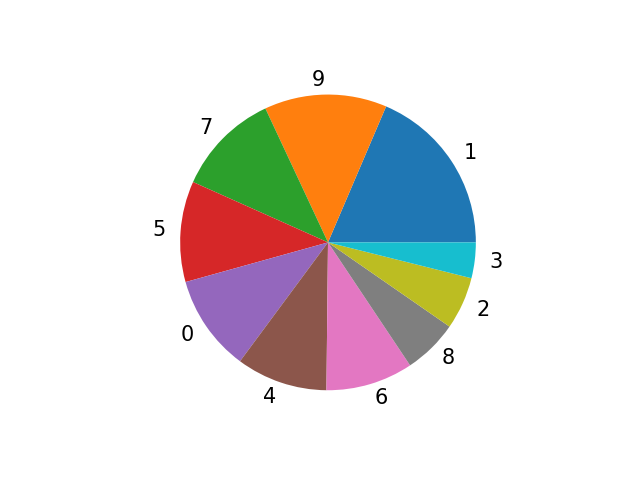

Text(0, 0.5, ' ')

In [450]:
#num docs by dominant topic 
fig, ax = plt.subplots()

df_document_topic.groupby('dominant_topic')['index_data'].count().sort_values(ascending=False).plot.pie(ax=ax)

ax.set_ylabel(' ')

In [428]:
#num docs by dominant topic 
(df_document_topic.groupby('dominant_topic')['index_data'].count().sort_values(ascending=False)/4593)

dominant_topic
1    0.185717
9    0.133899
7    0.113433
5    0.110168
0    0.105378
4    0.099717
6    0.095363
8    0.059874
2    0.057479
3    0.038972
Name: index_data, dtype: float64

In [1248]:
#num docs by dominant topic 
(df_document_topic.groupby('dominant_topic')['index_data'].count().sort_values(ascending=False)/4593).cumsum()

dominant_topic
4     0.145656
11    0.261049
10    0.370564
1     0.461572
7     0.547355
9     0.628347
0     0.699325
14    0.765295
6     0.812759
2     0.855650
12    0.897888
5     0.940126
13    0.962769
8     0.984106
3     1.000000
Name: index_data, dtype: float64

In [1243]:
#num docs by dominant topic 
df_document_topic.groupby('dominant_topic')['index_data'].count().sort_values(ascending=False)/4593

dominant_topic
4     669
11    530
10    503
1     418
7     394
9     372
0     326
14    303
6     218
2     197
12    194
5     194
13    104
8      98
3      73
Name: index_data, dtype: int64

In [431]:
selected_topics(lda, vectorizer)

Topic 0:
[('store', 135.4475758445999),
 ('grocery', 123.60284638696267),
 ('rate', 107.17176890825957),
 ('sale', 90.53429421874108),
 ('happy', 77.60900434458848),
 ('com', 76.19307683696175),
 ('friday', 74.72636202036236),
 ('deli', 73.87234688530624),
 ('online', 52.84676369698355),
 ('think', 44.59449444216761),
 ('website', 44.175956512724895),
 ('email', 44.126128603795436),
 ('advise', 42.83985363627372),
 ('family', 41.44399312129541),
 ('www', 37.59605319233576)]


Topic 1:
[('lro', 428.12427179777904),
 ('tenant', 299.2192444210773),
 ('eligible', 211.92360126488532),
 ('building', 210.11925141280133),
 ('lessor', 206.82411128956204),
 ('write', 168.9969398664257),
 ('occupy', 162.77882811388747),
 ('office', 142.2772918009501),
 ('guideline', 88.92509756397678),
 ('salon', 83.04080539846295),
 ('nail', 76.95421761411471),
 ('000', 76.34596637074335),
 ('shop', 70.36625699809423),
 ('sq', 68.83190003947313),
 ('ft', 63.98091759551101)]


Topic 2:
[('find', 129.4803880843671

## Topic 1

In [434]:
print_sample(get_representative_docs(1),3)

Num representative docs: 853
-------------
 
(03:51:28 PM) Cindy Yang: Can you write a nail salon with waxing?
(03:51:41 PM) Amit: Hi Cindy
(03:51:48 PM) Amit: we don't do body work/waxing
(03:51:48 PM) Amit: sorry
(03:51:50 PM) Cindy Yang: Hey again
(03:51:57 PM) Cindy Yang: heh, ok thanks anyway
(03:52:47 PM) Amit: no porblme
CUSTOMER
Can you write a nail salon with waxing? Hey again heh, ok thanks anyway
CLEANED
write nail salon waxing heh
-------------
 
(09:13:46 PM) Jill Al-Atar: I have an LRO exposure occupied by a furniture store, but they have a separate location for the store parking lot. Is this risk eligible for your BOP?
(09:13:59 PM) Andrianna Q.: Hi Jill
(09:14:01 PM) Andrianna Q.: Happy Friday!
(09:15:13 PM) Jill Al-Atar: Do you need me to resubmit my inquiry?
(09:16:01 PM) Andrianna Q.: unfortunately, this risk is not in our appetite at the moment
(09:17:03 PM) Jill Al-Atar: thank you.
(09:17:14 PM) Andrianna Q.: you're welcome Jill
(09:17:19 PM) Andrianna Q.: Is there

## Topic 9

In [440]:
print_sample(get_representative_docs(9),3)

Num representative docs: 615
-------------
 
(03:36:08 PM) Jae: Hi
(03:36:15 PM) Jae: I have a cell phone repair store
(03:36:26 PM) Jae: can I use the electronic store class code for this?
(03:36:29 PM) Amit: Hi Jae
(03:36:32 PM) Jae: Hi Amit
(03:36:40 PM) Amit: just repairs
(03:36:41 PM) Amit: or sales too
(03:37:19 PM) Jae: I'll have to ask that, but description on app states repair store so I'm assuming just repairs
(03:37:31 PM) Amit: if it is just repairs we don' have a class
(03:37:37 PM) Amit: if they have some sales you can use electronic store
(03:37:44 PM) Jae: Okay
(03:38:01 PM) Jae: So if its repairs only, then you wont write it, correct?
(03:38:13 PM) Amit: correct
(03:38:16 PM) Jae: Got it.
(03:38:17 PM) Jae: Thanks
(03:38:20 PM) Amit: see ya
CUSTOMER
Hi I have a cell phone repair store can I use the electronic store class code for this? Hi Amit I'll have to ask that, but description on app states repair store so I'm assuming just repairs Okay So if its repairs only, the

## Topic 5

In [442]:
print_sample(get_representative_docs(5),3)

Num representative docs: 506
-------------
 
(07:04:21 PM) michele: Signs promotional products and vehicle wraps?? Do we have a home
(07:04:32 PM) Amit: Hello
(07:04:34 PM) Amit: advertising is fine
(07:04:36 PM) Amit: office
(07:04:52 PM) michele: okay so under office
(07:04:55 PM) Amit: correct
(07:04:58 PM) Amit: or printing
(07:05:00 PM) michele: TY :-)
(07:05:31 PM) Amit: no problem
(07:05:32 PM) Amit: take care

CUSTOMER
Signs promotional products and vehicle wraps?? Do we have a home okay so under office TY :-)
CLEANED
sign promotional product vehicle wrap home office
-------------
 
(02:49:36 PM) Tiffany: hello- i am looking on the classcode list - i dont see household items for wholesalers - luike toilet paper, detergent, towels, cooking utencils, socks, scarfs, hats
(02:51:01 PM) Steven: Hi, my name is Steven. We only have Appliance Distributors - Household and Home Furnishings in the wholesaler list.
(02:51:32 PM) Tiffany: ok
(02:51:36 PM) Tiffany: so for a variety like this

## Topic 0

In [446]:
print_sample(get_representative_docs(0),3)

Num representative docs: 484
-------------
 
(04:05:34 PM) Jeffrey VanCleave: Hello,.
Do y'all do Grocery stores that are open 24 hours?
(04:05:46 PM) Connor: Hi Jeffrey
(04:06:02 PM) Connor: We are not a market for grocery stores or 24 hour exposures
(04:06:24 PM) Jeffrey VanCleave: Thank yuo!
CUSTOMER
Hello,. Thank yuo!
CLEANED
yuo
-------------
 
(05:15:49 PM) Terri Clifford: good afternoon
I have a deer processing account and the code is meat, fish, poultry or seafood processing in airtight containers. Your manual shows Meat, Fish, Poultry or Seafood - Retail - Meat or Poultry. Would this fit?
(05:15:59 PM) Amit: Hello
(05:16:11 PM) Amit: we don't really do meat processing
(05:17:11 PM) Terri Clifford: ok thank you - and HEY!
(05:17:23 PM) Amit: hello

CUSTOMER
good afternoon ok thank you - and HEY!
CLEANED

-------------
 
(07:49:59 PM) Daniel: Please advise if Blackboard would consider Janitorial services as a class
(07:50:10 PM) Jessica P.: Hi Daniel
(07:50:19 PM) Daniel: Good a

## Topic 4

In [448]:
print_sample(get_representative_docs(4),5)

Num representative docs: 458
-------------
 
(08:53:52 PM) Nancy: Can you please confirm Property Type to be used when a building have both mercantile exposure and 2 residential apartment exposure. Merc exposure is operated by Named Insured.
(08:55:04 PM) Connor: Hi Nancy
(08:55:10 PM) Nancy: Hi Connor
(08:55:32 PM) Connor: we are not a market for residential/habitational exposures
(08:55:47 PM) Nancy: Even when the majority is merc?
(08:57:36 PM) Connor: correct, no mixed use at all
CUSTOMER
Can you please confirm Property Type to be used when a building have both mercantile exposure and 2 residential apartment exposure. Merc exposure is operated by Named Insured. Hi Connor Even when the majority is merc?
CLEANED
confirm property type building mercantile exposure 2 residential apartment merc operate name insure majority
-------------
 
(09:21:24 PM) georgette diaz: quick question what bakery classification do I put for a bakery that bakes pastries, cakes, bread, ect...it is in a wareh

## Topic 9

In [1290]:
print_sample(get_representative_docs(9),5)

Num representative docs: 372
-------------
 
(01:25:35 PM) Jennifer Olivares: Good Morning! I have a tattoo parlor looking for premises GL for landlord requirements would you be a market ?
(01:26:10 PM) Mellisa M.: Good morning Jennifer!
(01:26:27 PM) Mellisa M.: Unfortunately tattoo parlors are ineligible at the moment
(01:26:34 PM) Jennifer Olivares: ok thank so much!
(01:26:36 PM) Jennifer Olivares: have a good week
(01:26:54 PM) Mellisa M.: You are very welcome!
(01:26:56 PM) Mellisa M.: You too!

CUSTOMER
Good Morning! I have a tattoo parlor looking for premises GL for landlord requirements would you be a market ? ok thank so much! have a good week
CLEANED
tattoo parlor look premise gl landlord requirement week
-------------
 
(09:12:37 PM) maria: I have an insured that is a wholesaler for lighting/bulbs (electric goods) the owner owns the bldg. under 1 Corp and leases to his other Corpp. same ownership. is this acceptable ?
(09:13:43 PM) Jessica P.: Hi Maria
(09:14:03 PM) Jessica

## Topic 0

In [1294]:
print_sample(get_representative_docs(0),5)

Num representative docs: 326
-------------
 
(06:02:08 PM) Ruby: hi
(06:02:23 PM) Ruby: quote # 0034782588
(06:02:25 PM) Connor: hi ruby
(06:02:48 PM) Ruby: hi Connor
(06:03:00 PM) Ruby: M K X 99 Cents &amp; Up Inc
(06:03:05 PM) Ruby: quote # 0034782588
(06:03:10 PM) Connor: whats going on with this quote
(06:03:18 PM) Ruby: there is a loss over $21,000
(06:03:34 PM) Ruby: can i send you the loss run?
(06:04:10 PM) Connor: 21k loss would make the submission ineligible
(06:04:47 PM) Connor: No more than three claims in the past 5 years, with no loss exceeding $20,000 (total
incurred, does not include catastrophe losses)
(06:04:50 PM) Ruby: cant refer for approval?
(06:05:36 PM) Connor: at this time we would not be able to get approval for loss experience being outside of appetitie
(06:05:40 PM) Connor: appetite*
(06:06:12 PM) Ruby: i see
(06:06:13 PM) Ruby: thank you
CUSTOMER
hi quote # 0034782588 hi Connor M K X 99 Cents &amp; Up Inc quote # 0034782588 there is a loss over $21,000 can 

## Topic 14

In [1296]:
print_sample(get_representative_docs(14),5)

Num representative docs: 303
-------------
 
(02:49:50 PM) Raymond Cheng: Hi. Insured is LOR With 2 apartment units and one accounting office. Is this eligible?
(02:49:59 PM) Amit: hello
(02:50:02 PM) Raymond Cheng: hi
(02:50:04 PM) Amit: sorry we don't do habitational/residential
(02:50:12 PM) Raymond Cheng: ok np
(02:50:13 PM) Raymond Cheng: thanks

CUSTOMER
Hi. Insured is LOR With 2 apartment units and one accounting office. Is this eligible? hi ok np thanks
CLEANED
insure lor 2 apartment unit accounting office eligible np
-------------
 
(07:28:37 PM) Joseph: I'm quoting a lessor's risk where the tenant is a property management company, but I can't find this classification. Can you assist?
(07:28:48 PM) Connor: hi joseph
(07:28:57 PM) Joseph: Hellio
(07:28:59 PM) Connor: is that the only occupant?
(07:28:59 PM) Joseph: Hello
(07:29:02 PM) Joseph: Yes
(07:29:45 PM) Connor: is this a real estates office? or are the purchasing properties/constructing building ?
(07:30:39 PM) Joseph: T

## Topic 12

In [1303]:
print_sample(get_representative_docs(12),5)

Num representative docs: 194
-------------
 
(07:15:09 PM) Terri Clifford: good afternoon
(07:15:24 PM) Connor: Hi Terrir
(07:15:28 PM) Connor: Terri*
(07:15:44 PM) Terri Clifford: can you write a nail salon
(07:15:58 PM) Terri Clifford: hi
(07:17:26 PM) Connor: Yes!
(07:17:29 PM) Connor: We can
(07:17:44 PM) Terri Clifford: what is it under
(07:18:09 PM) Connor: Under Beauty Parlors &amp; Hair Styling Salons 71952

CUSTOMER
good afternoon can you write a nail salon hi what is it under
CLEANED
write nail salon
-------------
 
(07:13:02 PM) Amy: Good afternoon
(07:13:24 PM) Diana A.: Hi Amy!
(07:13:37 PM) Diana A.: How can I help you today?
(07:13:44 PM) Amy: Hi Diana. Can you confirm if Tanning Salons are acceptable?
(07:14:32 PM) Diana A.: Regretfully, that is not acceptable.
(07:15:07 PM) Amy: ok, thank you
(07:15:13 PM) Diana A.: Sure
(07:15:19 PM) Diana A.: Happy New Year!!

CUSTOMER
Good afternoon Hi Diana. Can you confirm if Tanning Salons are acceptable? ok, thank you
CLEANED
co

###  Brokers

<IPython.core.display.Javascript object>


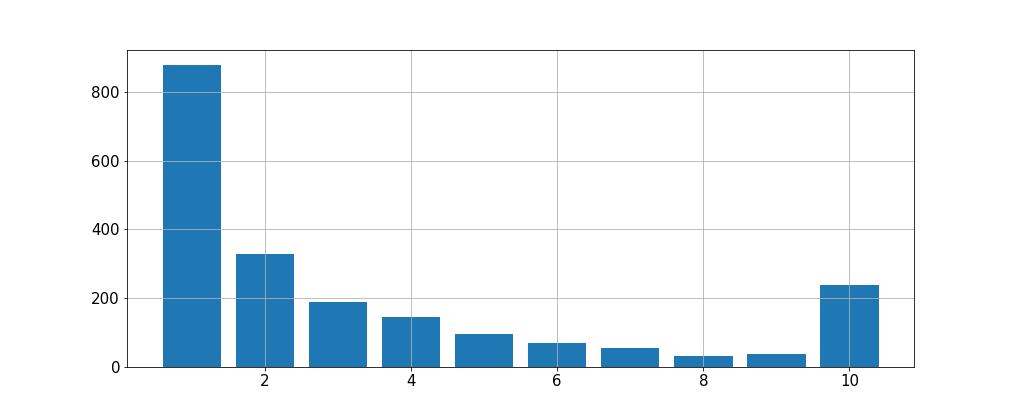

In [1062]:
data = np.histogram(df_pipe.r_name.value_counts().values,bins=[1,2,3,4,5,6,7,8,9,10,1000])
fig, ax = plt.subplots()
ax.bar(data[1][:-1],data[0])
ax.grid()

<IPython.core.display.Javascript object>


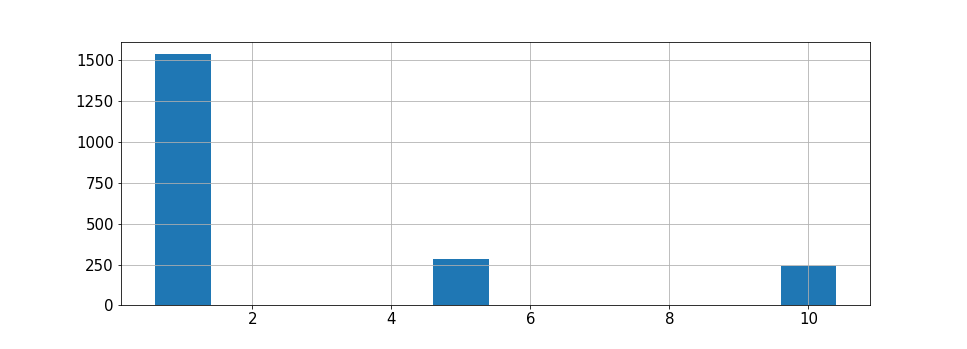

In [1059]:
data = np.histogram(df_pipe.r_name.value_counts().values,bins=[1,5,10,1000])
fig, ax = plt.subplots()
ax.bar(data[1][:-1],data[0])
ax.grid()

In [1092]:
broker_type = pd.DataFrame(data = df_pipe.r_name.value_counts().map(lambda x: 'active' if x>=5 else 'inactive')).reset_index().\
rename(columns={'index':'r_name','r_name':'broker_type'})

In [1099]:
broker_type.broker_type.value_counts()

inactive    1535
active       525
Name: broker_type, dtype: int64

In [1100]:
df_pipe = df_pipe.merge(broker_type,how='left', on='r_name')

In [1106]:
df_pipe[df_pipe.rounded_total_time<=10].groupby('broker_type')['t_id'].count()

broker_type
active      5124
inactive    1885
Name: t_id, dtype: int64

In [1104]:
df_pipe.groupby('broker_type')['t_id'].count()

broker_type
active      6816
inactive    2666
Name: t_id, dtype: int64

In [1104]:
df_pipe.groupby('broker_type').agg()

broker_type
active      6816
inactive    2666
Name: t_id, dtype: int64

In [1109]:
df_pipe[df_pipe.broker_type=='inactive'].rounded_total_time.describe()

count    2658.000000
mean        8.749059
std         8.340731
min         0.000000
25%         3.000000
50%         6.000000
75%        12.000000
max        95.000000
Name: rounded_total_time, dtype: float64

In [1110]:
df_pipe[df_pipe.broker_type=='active'].rounded_total_time.describe()

count    6800.000000
mean        8.069118
std         8.258433
min         0.000000
25%         3.000000
50%         5.000000
75%        10.000000
max       142.000000
Name: rounded_total_time, dtype: float64

In [1163]:
def get_ticket_time_ts(grp):
    ts = grp[['t_created', 'rounded_total_time']]
    ts.set_index('t_created',inplace=True)
    return ts.resample('d').mean().fillna(0).rounded_total_time

In [1161]:
# df_pipe[['t_created', 'rounded_total_time']].set_index('t_created').resample('d').mean().fillna(0)

In [1168]:
broker_daily_ts = df_pipe[df_pipe.broker_type=='active'].groupby('r_name').apply(get_ticket_time_ts)

In [1177]:
broker_daily_ts.head()

r_name  t_created 
AARON   2019-01-07    20.0
        2019-01-08     0.0
        2019-01-09     0.0
        2019-01-10     0.0
        2019-01-11     0.0
Name: rounded_total_time, dtype: float64

## TFIDF

### Sklearn

In [627]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [628]:
# data = [' '.join(d) for d in docs]
data = merged_chat_ticket_processing.stop.values

In [629]:
tfidf = TfidfVectorizer(max_df=.9, max_features=1000)
tfv = tfidf.fit_transform(data)

In [454]:
# tfidf.get_feature_names()

In [696]:
tfv[1].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.06622361,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08734121, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.12389167, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

View top weight words by document by TFxIDF, or top words by IDF overall

In [518]:
#asc sorting of IDF weight index
idf_sorting =  tfidf.idf_.argsort()

In [519]:
tfidf.idf_[idf_sorting]

array([1.61050401, 1.78902696, 1.88162495, 1.93255644, 1.94062751,
       2.04352991, 2.09104843, 2.21276384, 2.24373498, 2.25884491,
       2.28441983, 2.41052309, 2.41702648, 2.44974381, 2.47800457,
       2.5209864 , 2.53508141, 2.56136608, 2.58269752, 2.58578235,
       2.59301753, 2.64846883, 2.66115866, 2.6672851 , 2.67064269,
       2.7106709 , 2.71887247, 2.72951716, 2.7366771 , 2.78200022,
       2.78325414, 2.81253695, 2.82423299, 2.82750631, 2.85005369,
       2.87587034, 2.87862706, 2.88624746, 2.92163686, 2.95162082,
       2.96733383, 2.96733383, 2.97794803, 3.00107936, 3.01601088,
       3.02396005, 3.03358322, 3.06717917, 3.10021902, 3.10280634,
       3.11496983, 3.11584434, 3.12728309, 3.13349705, 3.15692154,
       3.20261714, 3.24054098, 3.25451326, 3.26056167, 3.26056167,
       3.2758447 , 3.29345261, 3.3018472 , 3.31777956, 3.3188508 ,
       3.32746226, 3.33288233, 3.33614853, 3.35820014, 3.36603454,
       3.36828426, 3.36941102, 3.37733409, 3.40615453, 3.40732

In [520]:
np.array(tfidf.get_feature_names())[idf_sorting]

array(['help', 'thank', 'class', 'quote', 'today', 'risk',
       'unfortunately', 'moment', 'day', 'write', 'yes', 'problem',
       'eligible', 'sorry', 'need', 'store', 'okay', 'look', 'bop',
       'business', 'question', 'office', 'building', 'sure', 'don',
       'check', 'guideline', 'know', 'appetite', 'time', 'use', 'insure',
       'tenant', 'account', 'want', 'like', 'com', 'lro', 'ineligible',
       'able', 'correct', 'get', 'restaurant', 'attune', 'let', 'email',
       'try', 'happy', 'amp', 'location', 'work', 'retail', 'review',
       'confirm', 'fine', 'contact', 'think', 'feel', 'chat', 'care',
       'coverage', 'free', 'sell', 'service', 'rate', 'classification',
       'type', 'outside', 'decline', 'lessor', 'shop', 'ask', 'reach',
       'market', 'address', 'find', 'sale', 'will', 'new', 'rest', 'send',
       'provide', 'number', 'website', 'classify', 'exposure', 'https',
       'consider', 'occupy', 'underwriting', 'product', 'system', 'right',
       'advis

by document

In [532]:
tfidf.get_feature_names()[915]

'today'

In [536]:
tfidf.vocabulary_['today']

915

In [ ]:
#sort tfidf vectors by doc descending, top n
features_array = np.array(tfidf.get_feature_names())

In [571]:
#get top n features and corresponding weights
n=10
top_n_tfidf_inds = np.fliplr(tfv.toarray().argsort(axis=1))[:,:n]
top_n_tfidf_weights = np.fliplr(np.sort(tfv.toarray(),axis=1))[:,:n]
top_n_tfidf_features = features_array[top_n_tfidf_inds]

In [573]:
top_n_tfidf_features

array([['ny', 'janitorial', 'classcode', ..., 'attach', 'wc', 'quick'],
       ['dental', 'insure', 'office', ..., 'owner', 'ashl', 'lessor'],
       ['food', 'inconvenience', 'hard', ..., 'have', 'see', 'specific'],
       ...,
       ['owner', 'lro', 'brooklyn', ..., 'building', 'ny', '10'],
       ['profit', 'non', 'organization', ..., 'answer', 'enjoy', 'come'],
       ['music', 'art', 'studio', ..., 'amp', 'able', 'ineligible']],
      dtype='<U15')

In [574]:
top_n_tfidf_weights

array([[0.33868912, 0.27006524, 0.25058288, ..., 0.21494974, 0.18746412,
        0.17913331],
       [0.5664543 , 0.26349205, 0.24812136, ..., 0.17954216, 0.16070272,
        0.15767319],
       [0.35138469, 0.26743276, 0.26334641, ..., 0.21571868, 0.2151303 ,
        0.21322189],
       ...,
       [0.30545915, 0.2300168 , 0.21298525, ..., 0.15905891, 0.15654883,
        0.15440682],
       [0.4819728 , 0.36304465, 0.26062326, ..., 0.18830404, 0.16241847,
        0.16234063],
       [0.5296542 , 0.50875012, 0.45252782, ..., 0.13504277, 0.12856996,
        0.12726389]])

### Gensim 

In [981]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

//anaconda3/envs/zendesk/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping
//anaconda3/envs/zendesk/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [1047]:
#create mapping between words and integer IDs
#https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary
docs_dict = Dictionary(docs)

In [1076]:
print(docs_dict)

Dictionary(28284 unique tokens: ['9028', 'afternoon', 'appetite', 'attach', 'attribute']...)


In [50]:
# sorted([(docs_dict[k],v) for k,v in docs_dict.dfs.items()], key=lambda x: x[1], reverse=True)

In [52]:
# [(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

In [ ]:
# docs_dict.filter_extremes(no_below=20, no_above=0.2)
# docs_dict.compactify()

In [1049]:
#convert each doc to BOW rep (counts of word IDs per doc)
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]

In [53]:
# docs_corpus[0]

In [1051]:
#transform  bow vectors to tfidf vectors
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]

In [1054]:
#view sample
[(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

[('dental', 0.5803287266730481),
 ('insuredbusiness', 0.26154100149465176),
 ('surgeriessedation', 0.26154100149465176),
 ('earlier', 0.25008827112587595),
 ('63981', 0.16536743993664402),
 ('owner', 0.16519462849918568),
 ('insure', 0.1640982076570375),
 ('ashly', 0.16346266312623767),
 ('bind', 0.1631676734607926),
 ('tenant', 0.15630612124484414),
 ('lessor', 0.14531138445969344),
 ('office', 0.1428583241502388),
 ('building', 0.14190627879127143),
 ('offices', 0.14102735953469592),
 ('chat', 0.12192079215897975),
 ('alright', 0.12102109700017323),
 ('risk', 0.11745236143687482),
 ('m', 0.10788539312817073),
 ('own', 0.09999984085607022),
 ('enter', 0.09769837618370808),
 ('check', 0.09685718175839256),
 ('hear', 0.09256795844007877),
 ('gl', 0.09158430130080662),
 ('case', 0.08999314692542257),
 ('quick', 0.08957415065422689),
 ('ok', 0.08913850038157992),
 ('look', 0.08887368137877899),
 ('need', 0.0838487173558619),
 ('eligible', 0.07770756042948618),
 ('go', 0.07712877123968771)

In [1055]:
#convert vectors in bow format to dense vectors dim n_doc x len_dict
docs_vecs  = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [1063]:
docs_vecs

array([[0.4047528 , 0.21239552, 0.07665578, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09729766, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1572759 , 0.3145518 ,
        0.3145518 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [1059]:
docs_vecs.shape

(9483, 28284)

### KNN with cosine

In [630]:
from sklearn.neighbors import NearestNeighbors

In [631]:
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfv)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [632]:
top_n_tfidf_features[0]

array(['ny', 'janitorial', 'classcode', 'class', 'noc', 'clarify',
       'entertain', 'attach', 'wc', 'quick'], dtype='<U15')

In [380]:
print('\x1b[1;03;30;43m'+'Hello'+'\x1b[0m')

Hello


In [699]:
dist, inds =  nn.kneighbors(tfv[3])
for i, d in enumerate(dist[0]):
    print('--------------------'+' Distance: {:.3f}'.format(d))
    text = merged_chat_ticket_processing.comment_text.iloc[inds[0][i]]
    wa
    print(text)

-------------------- Distance: 0.000
 
(08:01:53 PM) Drew Burks: Does Attune write for a virtual realty game business.
(08:09:08 PM) Tristan S.: Hi Drew!
(08:09:21 PM) Drew Burks: Hey Tristan
(08:09:26 PM) Tristan S.: That would fall out of our appetite unfortunately
(08:09:45 PM) Drew Burks: Ok. I didn't see that specifically in the guidelines
(08:10:09 PM) Tristan S.: Yes, we don't have a class code for this currently.
(08:10:31 PM) Drew Burks: Ok. No problem. Thank you for your time. That is all I need right now
(08:12:06 PM) Tristan S.: Have a good day!

-------------------- Distance: 0.501
 
(06:12:31 PM) Drew Burks: I have a quick question on a possible risk. Does Attune write arcades?
(06:12:51 PM) Amit: Hello
(06:12:55 PM) Amit: unfortunately we don't Drew, sorry
(06:13:27 PM) Drew Burks: I didn't see it specifically in the guidelines, so I thought I would ask. Thank you, Amit
(06:13:32 PM) Amit: no problem
(06:13:34 PM) Amit: take care
-------------------- Distance: 0.613
 
(0

## Kmeans on TFIDF

In [666]:
from sklearn.cluster import KMeans

In [682]:
# Sum_of_squared_distances = []
K = range(70,111,20)

for k in K:
    time_start = time.time()
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=300)
    km = km.fit(tfv)
    Sum_of_squared_distances.append(km.inertia_)
    print('kmeans {} done! Time elapsed: {} seconds'.format(k,time.time()-time_start))

kmeans 70 done! Time elapsed: 83.62015056610107 seconds
kmeans 90 done! Time elapsed: 74.06711769104004 seconds
kmeans 110 done! Time elapsed: 76.81947302818298 seconds


<IPython.core.display.Javascript object>


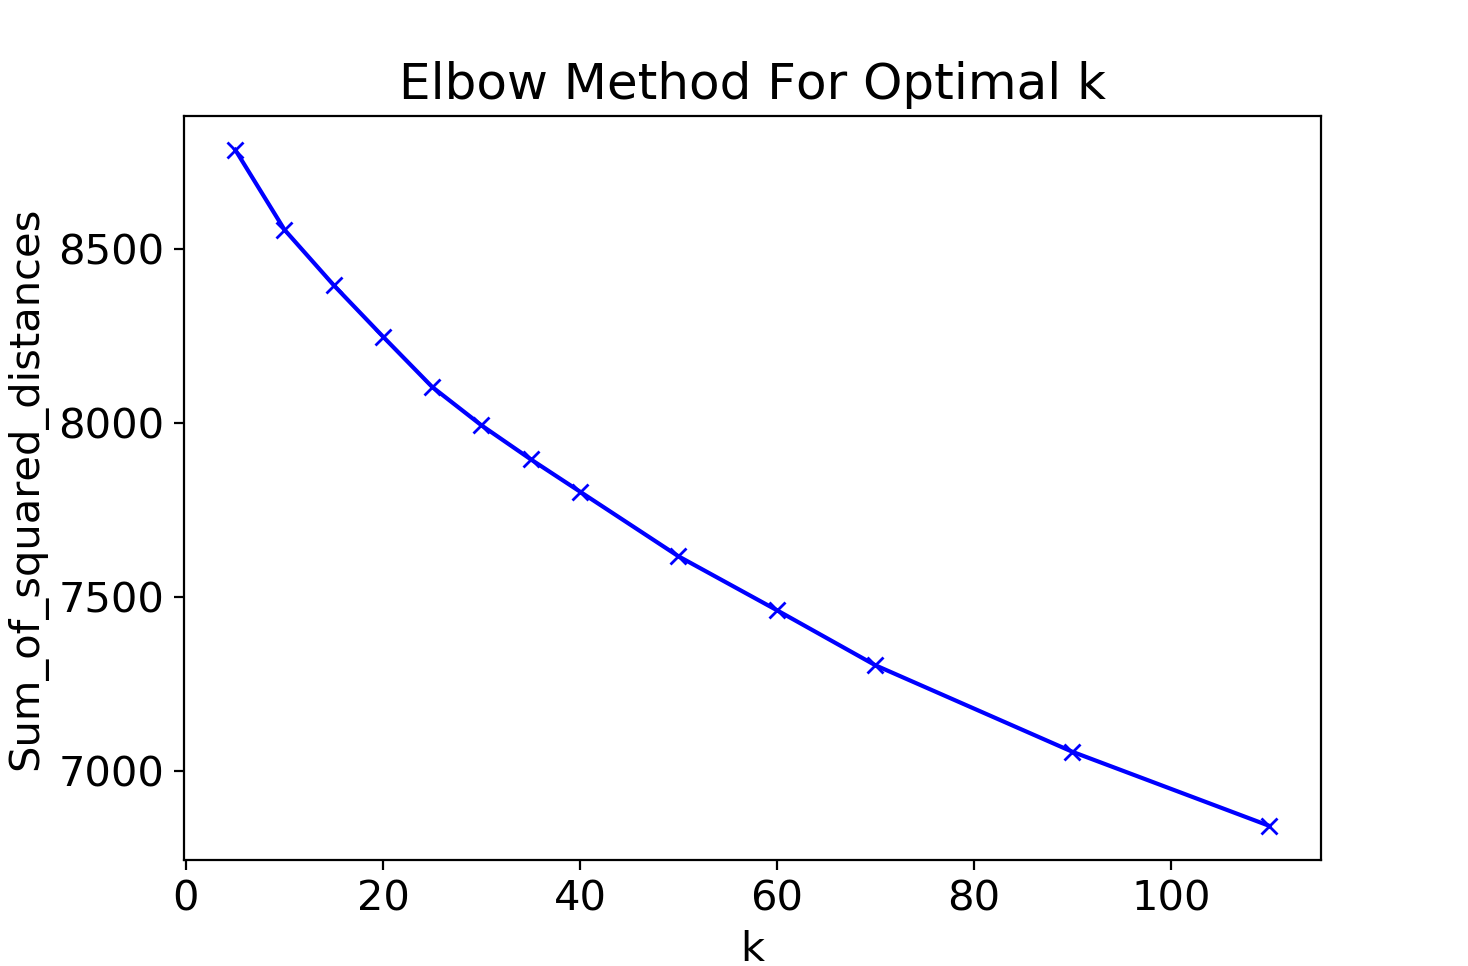

In [683]:
plt.plot([5,10,15,20,25,30,35,40,50,60,70,90,110], Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

widget visualization for cluster content

In [ ]:
#preprocess, tokenize (bigrams, trigrams, vectorize, transform (tfidf, lsi, lda), cluster/classify

### Evaluation of clusters

## Other Embeddings

## Labeling with macros

In [700]:
tcdf = df[df.comment_text.str.contains('Thank you for contacting us')].copy()

In [701]:
def phrase_label(text):
    
    e = ['Yes, we currently write', 'The class code for']
    ne = ['currently do not write', 'not an eligible class', 'nfortunately']
    
    if any([phrase in text for phrase in e]):
        return 'eligible'
    elif any([phrase in text for phrase in ne]):
        return 'not eligible'
    elif 'reason you were declined' in text:
        return 'declined'
    else:
        return None

In [702]:
#count nulls
tcdf['label'] = tcdf.comment_text.map(phrase_label)

In [703]:
tcdf.head()

t_id           t_created                r_name          r_id  \
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
5  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   
7  148929 2019-09-19 21:21:50        Georgette Diaz  377333939872   
9  148925 2019-09-19 21:19:42     Vincent Mosomillo  363659707672   

           a_id    a_name                     subject  \
1  374984390592  Shane C.           Chat with Jeannie   
3  374984390592  Shane C.            Chat with denise   
5  374984390592  Shane C.         Chat with jeff wolf   
7  374984390592  Shane C.    Chat with georgette diaz   
9  374984390592  Shane C.  Chat with Vncent Mosomillo   

                                        comment_text text_type         label  
1  Hi Jeannie,\nThank you for contacting us. The ...     macro      eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...     macro  not eligible  
5  Hi Jeffrey,\nThank you for contacting us.\nYes...     macro      eligible  
7  Hi Georgette,\nThank you for contacting us.\nA...     macro  not eligible  
9  Hi Vincent,\nThank you for contacting us.\nAt ...     macro  not eligible

In [704]:
tcdf.label.isnull().sum()

112

In [705]:
tcdf.label.value_counts()

not eligible    844
eligible        463
declined         64
Name: label, dtype: int64

Check distributions of macro responses vs general chat

In [514]:
# df.drop('label',axis=1,inplace=True)

In [12]:
df['text'] = df.comment_text.str.contains('Thank you for contacting us').map(lambda x: 'macro' if x else 'chat')

In [532]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

<IPython.core.display.Javascript object>


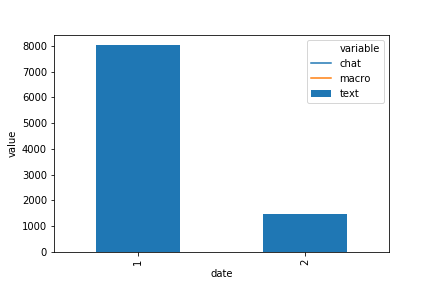

In [553]:
#number of tickets that include macro responses for labeling
df.groupby('t_id')['text'].nunique().value_counts().plot.bar()

In [554]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

In [559]:
ttdf = df[['t_created','text']].copy()

In [572]:
ttdf['date'] = ttdf.t_created.map(lambda x: x.date())

In [616]:
ts = ttdf.groupby(['date','text']).count().unstack(fill_value=0)

In [630]:
ts.columns = ['chat','macro']

In [632]:
ts.head()

chat  macro
date                   
2018-02-16     1      0
2018-02-20    18      0
2018-02-21    10      1
2018-02-22    14      1
2018-02-23    10      0

In [643]:
#long form for seaborn plotting
ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']).head()

date variable  value
0  2018-02-16     chat      1
1  2018-02-20     chat     18
2  2018-02-21     chat     10
3  2018-02-22     chat     14
4  2018-02-23     chat     10

Number of tickets per day that have macro responses. Ideal would be all?

<IPython.core.display.Javascript object>


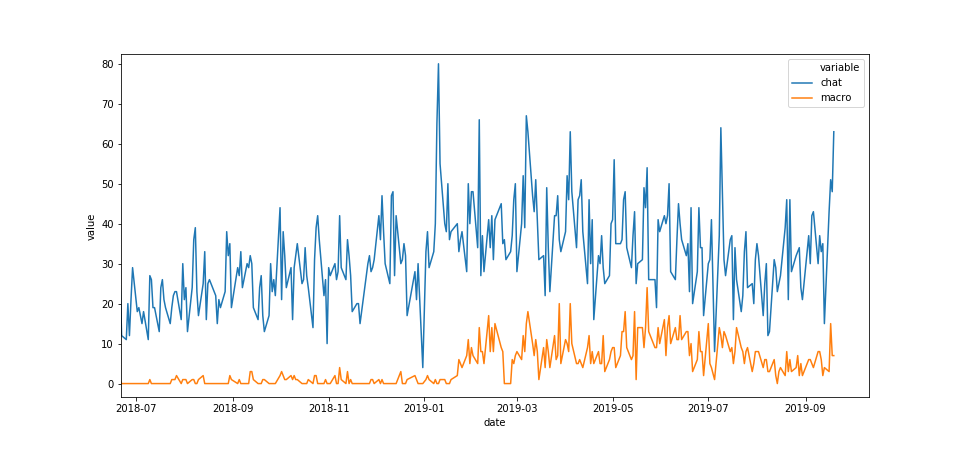

In [646]:
fig, ax= plt.subplots()
sns.lineplot(x='date', y='value',hue='variable',
             data=ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']),ax=ax)

Apply template phrases to larger dataset (need to verify accuracy of phrases)

In [447]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text         label  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...          None  
1  Hi Jeannie,\nThank you for contacting us. The ...      eligible  
2   \n(09:22:45 PM) denise: Do you allow electric...  not eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...  not eligible  
4   \n(09:21:52 PM) jeff wolf: what is best class...  not eligible

In [415]:
df['label'] = df.comment_text.map(phrase_label)

In [422]:
df.label.value_counts()/12845

not eligible    0.325963
eligible        0.036902
declined        0.005216
Name: label, dtype: float64

In [455]:
print(df[df.label=='not eligible'].comment_text[16])

 
(08:26:38 PM) Michelle Lee: Good Afternoon
I have a risk that is a lessors Risk
they have 2 Whole sales tenants - one is Jewelry and the other is a camera distributor
can we entertain this risk?
(08:27:30 PM) Michelle Lee: Hi Ashl'Y
(08:28:17 PM) Ashl'Y M.: hey Michelle the jewelry wholesale is okay
(08:28:24 PM) Ashl'Y M.: let me check on the camera
(08:28:26 PM) Ashl'Y M.: One moment please
(08:28:28 PM) Michelle Lee: thank you
(08:33:06 PM) Ashl'Y M.: how much space does the camera occupy
(08:33:54 PM) Michelle Lee: the total sq ft for the building is 10,000
Jewelry - 7,000
Camera Distributor - 3,000
(08:37:34 PM) Ashl'Y M.: okay unfortunately we wouldnt be able to write this because of the camera
(08:37:42 PM) Michelle Lee: thank you for trying
(08:37:44 PM) Michelle Lee: have a great day
(08:37:51 PM) Ashl'Y M.: you as well

